## <font color='darkblue'>Preface</font>
([article source](https://keras.io/examples/nlp/text_classification_with_transformer/)) <b><font size='3ptx'>Implement a Transformer block as a Keras layer and use it for text classification.</font></b>

Transformers are deep neural networks based on [**attention**](https://developers.google.com/machine-learning/glossary#attention). It replaces CNNs and RNNs with [**self-attention**](https://developers.google.com/machine-learning/glossary#self-attention). Attention allows Transformers to access information from distant positions in the input sequence.

As explained in the [*Google AI Blog post*](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):
> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

### <font color='darkgreen'>Agenda</font>
* <b><font size='3ptx'><a href='#sect1'>Prepare dataset</a></font></b>
* <b><font size='3ptx'><a href='#sect2'>Build ML model</a></font></b>
* <b><font size='3ptx'><a href='#sect3'>Train & Evaluation</a></font></b>

### <font color='darkgreen'>Setup</font>

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

2022-09-23 04:31:12.880268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 04:31:13.094482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 04:31:13.094533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-23 04:31:13.137283: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-23 04:31:13.982193: W tensorflow/stream_executor/platform/de

<a id='sect1'></a>
## <font color='darkblue'>Prepare dataset</font>

### <font color='darkgreen'>Download and prepare dataset</font>
* [Keras doc - IMDB movie review sentiment classification dataset](https://keras.io/api/datasets/imdb/)

In [2]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 250  # Only consider the first 200 words of each movie review
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(X_train), "Training sequences")
print(len(X_test), "Validation sequences")
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


<a id='sect2'></a>
## <font color='darkblue'>Build ML model</font>
* <b><font size='3ptx'><a href='#sect2_1'>Implement a Transformer block as a layer</a></font></b>
* <b><font size='3ptx'><a href='#sect2_2'>Implement embedding layer</a></font></b>
* <b><font size='3ptx'><a href='#sect2_3'>Create classifier model using transformer layer</a></font></b>
* <b><font size='3ptx'>Reference</font></b>
    * **[Keras doc - The base Layer class](https://keras.io/api/layers/base_layer/)**: A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors.

<a id='sect2_1'></a>
### <font color='darkgreen'>Implement a Transformer block as a layer</font>
* [【機器學習2021】自注意力機制 (Self-attention) (上)](https://www.youtube.com/watch?v=hYdO9CscNes)
* [【機器學習2021】自注意力機制 (Self-attention) (下)](https://www.youtube.com/watch?v=gmsMY5kc-zw)
* [【機器學習2021】Transformer (上)](https://www.youtube.com/watch?v=n9TlOhRjYoc)
* [【機器學習2021】Transformer (下)](https://www.youtube.com/watch?v=N6aRv06iv2g)
* [Keras doc - MultiHeadAttention layer](https://keras.io/api/layers/attention_layers/multi_head_attention/)

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

<a id='sect2_2'></a>
### <font color='darkgreen'>Implement embedding layer</font>
Two seperate embedding layers, one for tokens, one for token index (positions).
* [Keras doc - TokenAndPositionEmbedding layer](https://keras.io/api/keras_nlp/layers/token_and_position_embedding/)

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

<a id='sect2_3'></a>
### <font color='darkgreen'>Create classifier model using transformer layer</font>
<b>Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.</b>

In [5]:
def build_model(maxlen:int, vocab_size:int, embed_dim:int = 32, num_heads:int = 2, ff_dim:int = 32, dropout_rate=0.1):
    '''Builds Transform model.
    
    Args:
        maxlen: First `maxlen` words of each movie review to consider.
        vocab_size: Only consider the top `vocab_size` words.
        embed_dim: Embedding size for each token.
        num_heads: Number of attention heads.
        ff_dim: Hidden layer size in feed forward network inside transformer.
    '''
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate=dropout_rate)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(20, activation="linear", kernel_regularizer=regularizers.L2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(5, activation="linear", kernel_regularizer=regularizers.L2(1e-4))(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [6]:
transformer_model = build_model(maxlen=maxlen, vocab_size=vocab_size, dropout_rate=0.15)

2022-09-23 04:31:21.123157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-23 04:31:21.123211: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 04:31:21.123240: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (johnkclee.c.googlers.com): /proc/driver/nvidia/version does not exist
2022-09-23 04:31:21.123523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 token_and_position_embeddin  (None, 250, 32)          648000    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 250, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

<a id='sect3'></a>
## <font color='darkblue'>Train & Evaluation</font>

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
def draw_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

<a id='sect3_1'></a>
### <font color='darkgreen'>Train Model</font>

In [9]:
transformer_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = transformer_model.fit(
    X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
704/704 [==============================] - 57s 79ms/step - loss: 0.3888 - accuracy: 0.8183 - val_loss: 0.2977 - val_accuracy: 0.8812
Epoch 2/10
704/704 [==============================] - 52s 75ms/step - loss: 0.1951 - accuracy: 0.9277 - val_loss: 0.3012 - val_accuracy: 0.8780
Epoch 3/10
704/704 [==============================] - 52s 73ms/step - loss: 0.1298 - accuracy: 0.9544 - val_loss: 0.3165 - val_accuracy: 0.8876
Epoch 4/10
704/704 [==============================] - 54s 77ms/step - loss: 0.0863 - accuracy: 0.9728 - val_loss: 0.4524 - val_accuracy: 0.8648
Epoch 5/10
704/704 [==============================] - 52s 75ms/step - loss: 0.0529 - accuracy: 0.9838 - val_loss: 0.5002 - val_accuracy: 0.8712
Epoch 6/10
704/704 [==============================] - 53s 75ms/step - loss: 0.0381 - accuracy: 0.9873 - val_loss: 0.5443 - val_accuracy: 0.8728
Epoch 7/10
704/704 [==============================] - 52s 74ms/step - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.4928 - val_accuracy:

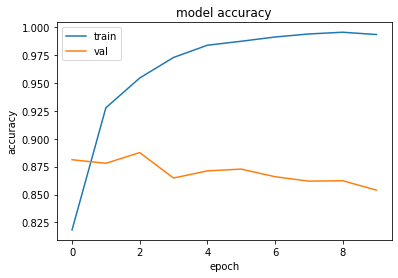

In [10]:
draw_history(history)

<a id='sect3_2'></a>
### <font color='darkgreen'>Evaluate Model</font>

In [11]:
y_pred = transformer_model.predict(X_test)

782/782 [==============================] - 25s 31ms/step


In [12]:
y_pred[:3]

array([[9.9994129e-01, 5.8668251e-05],
       [3.8750466e-05, 9.9996120e-01],
       [2.8769605e-04, 9.9971235e-01]], dtype=float32)

In [13]:
yhat = np.argmax(y_pred.round(), axis=1)

In [14]:
print(len(yhat))
yhat[:3]

25000


array([0, 1, 1])

In [15]:
print(len(y_test))
y_test[:3]

25000


array([0, 1, 1])

In [19]:
print(f'Accuracy={accuracy_score(y_test, yhat):.02%}')

Accuracy=84.01%


## <font color='darkblue'>Supplement</font>
* [Keras doc - Layer weight regularizers](https://keras.io/api/layers/regularizers/)
* [Tensorflow doc - Neural machine translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer)